In [1]:
import numpy as np
import kwant
from numpy import sqrt,pi,cos,sin,kron
from scipy.sparse.linalg import eigsh


#pauli matrix
sigma_0 = np.array([[1, 0],[0, 1]])
sigma_x = np.array([[0, 1],[1, 0]])
sigma_y = np.array([[0, -1j],[1j, 0]])
sigma_z = np.array([[1, 0],[0, -1]])

tau_0 = sigma_0
tau_x = sigma_x
tau_y = sigma_y
tau_z = sigma_z

def make_system_1D(L, delta, tw, ts, mu_w, mu_s, Zw, Zs, alpha, T, BdG=False, PBC=False):
    if PBC:
        sys = kwant.Builder(kwant.TranslationalSymmetry((1, 0)))
    else:
        sys = kwant.Builder()

    # Define lattice based on BdG formalism
    norbs = 4 if BdG else 2
    lat_w = kwant.lattice.square(a=1, norbs=norbs, name='W')
    lat_s = kwant.lattice.square(a=1, norbs=norbs, name='SC')

    def W_region(pos):
        x, y = pos
        return 0 <= x <= L and y == 0

    def SC_region(pos):
        x, y = pos
        return 0 <= x <= L and y == -1

    '''define hamiltonian'''
    # Wire Hamiltonian terms
    def W_onsite(site):
        if BdG:
            return (2 * tw - mu_w) * kron(tau_z, sigma_0) + Zw * kron(tau_0, sigma_x)
        return (2 * tw - mu_w) * sigma_0 + Zw * sigma_x

    def W_hop_x(site1, site2):
        if BdG:
            return -tw * kron(tau_z, sigma_0) + 1j * alpha / 2 * kron(tau_z, sigma_y)
        return -tw * sigma_0 + 1j * alpha / 2 * sigma_y

    # Superconductor Hamiltonian terms
    def SC_onsite(site):
        if BdG:
            return (2 * ts - mu_s) * kron(tau_z, sigma_0) + delta * kron(tau_x, sigma_0) + Zs * kron(tau_0, sigma_x)
        return (2 * ts - mu_s) * sigma_0 + Zs * sigma_x

    def SC_hop_x(site1, site2):
        return -ts * (kron(tau_z, sigma_0) if BdG else sigma_0)

    '''add onsite and hopping'''
    # Add sites and hoppings for superconductor
    sys[lat_s.shape(SC_region, (0, -1))] = SC_onsite
    sys[kwant.builder.HoppingKind((1, 0), lat_s, lat_s)] = SC_hop_x

    # Add sites and hoppings for wire
    sys[lat_w.shape(W_region, (0, 0))] = W_onsite
    sys[kwant.builder.HoppingKind((1, 0), lat_w, lat_w)] = W_hop_x

    # Add coupling between wire and superconductor
    coupling_term = T * (kron(tau_z, sigma_0) if BdG else sigma_0)
    sys[kwant.builder.HoppingKind((0, 1), lat_w, lat_s)] = coupling_term

    return sys




# electron bands


[-0.51231056 -0.51231056  0.31231056  0.31231056] 

0.06666666666666667 

-0.013333333333333336
-0.518731987993758


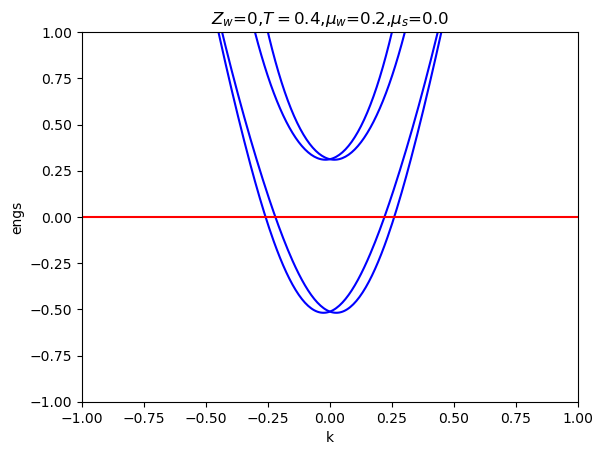

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import time
from numpy import sqrt,pi,cos,sin,kron,min,abs
from scipy.sparse.linalg import eigsh




L = 300
delta = 1
tw = 12
alpha = 0.8


ts = 6
mu_w = 0.2
mu_s = 0.
Zw = 0
Zs = 0

T = 0.4


def main():
    '''bands'''
    sys = make_system_1D(L = L, delta = delta, tw = tw, ts = ts, mu_w = mu_w, mu_s = mu_s, 
                   Zw = Zw, Zs = Zs, alpha = alpha, T = T, BdG = False, PBC = True).finalized()
    

    band_sys = kwant.physics.Bands(sys)
    momenta = np.linspace(-pi, pi, 1001)
    eng_sys = [band_sys(k) for k in momenta]

    # print(min(eng_sys))
    # print(min(abs(eng_sys)))

    zeros = 0. * np.ones(1001)
    plt.figure()
    plt.plot(momenta, eng_sys,'b')
    plt.plot(momenta, zeros,'r')
    plt.xlabel('k')
    plt.ylabel('engs')
    # plt.title(f'T={T},$B_w$={Vw},$\\Delta$={delta},$\\mu_w$={mu_w},$\\mu_s$={mu_s}')
    plt.title(f'$Z_w$={Zw},$T={T}$,$\\mu_w$={mu_w},$\\mu_s$={mu_s}')
    plt.ylim(-1,1)
    plt.xlim(-1,1)

    print(band_sys(0),'\n')

    # 看rashba的能带的零点和最低点
    print(alpha/tw,'\n')
    print(-alpha**2/(4*tw))
    print(min(np.array(eng_sys)))

if __name__ == "__main__":
    main()


# bdg 本征值和能带

0.0009181899387213339


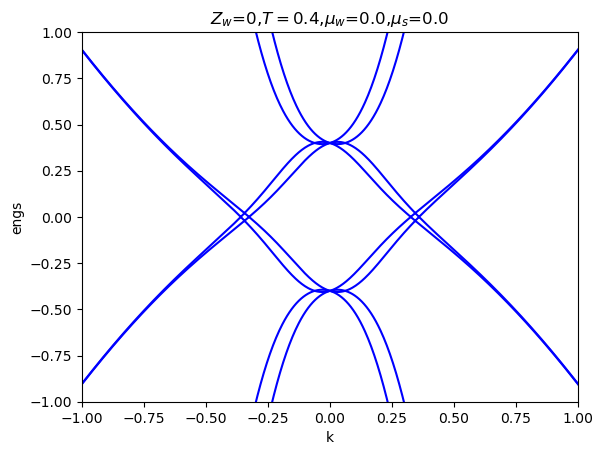

In [22]:
def main():

    L = 300
    delta = 0
    tw = 12
    alpha = 0.8
    
    ts = 1
    mu_w = 0.
    mu_s = 0.
    Zw = 0
    Zs = 0
    
    T = 0.4


    # '''eigenvalue'''
    # sys = make_system_1D(L = L, delta = delta, tw = tw, ts = ts, mu_w = mu_w, mu_s = mu_s,
    # Vw = Vw, Vs = Vs, alpha = alpha, T = T, BdG=True, PBC=False).finalized()

    # ham = sys.hamiltonian_submatrix(sparse = True)
    # energies,states = eigsh(ham, k = 40, sigma = 1e-10, return_eigenvectors = True)

    # plt.figure()
    # plt.plot(np.arange(len(energies)),np.sort(energies),'o')
    # plt.title(f'$V_w$={Vw}')
    # plt.show()

    '''bands'''
    sys = make_system_1D(L = L, delta = delta, tw = tw, ts = ts, mu_w = mu_w, mu_s = mu_s,
    Zw = Zw, Zs = Zs, alpha = alpha, T = T, BdG=True, PBC=True).finalized()

    band_sys = kwant.physics.Bands(sys)
    momenta = np.linspace(-pi, pi, 2001)
    eng_sys = [band_sys(k) for k in momenta]
    
    print(min(abs(eng_sys)))
    plt.figure()
    plt.plot(momenta, eng_sys,'b')
    plt.xlabel('k')
    plt.ylabel('engs')
    plt.title(f'$Z_w$={Zw},$T={T}$,$\\mu_w$={mu_w},$\\mu_s$={mu_s}')
    plt.ylim(-1,1)
    plt.xlim(-1,1)

if __name__ == "__main__":
    main()

# bands 手动调节图

In [5]:
%matplotlib tk

import numpy as np
import kwant
from numpy import pi
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

L = 300
delta = 1
tw = 12
alpha = 0.8
ts = 2
mu_s = 0.0
Zs = 0
T = 0.4

# 初始值
mu_w_init = 0.0
Zw_init = 0.0

def plot_bands(mu_w, Zw):
    sys = make_system_1D(L=L, delta=delta, tw=tw, ts=ts, mu_w=mu_w, mu_s=mu_s,
                         Zw=Zw, Zs=Zs, alpha=alpha, T=T, BdG=True, PBC=True).finalized()
    band_sys = kwant.physics.Bands(sys)
    momenta = np.linspace(-pi, pi, 2001)
    eng_sys = np.array([band_sys(k) for k in momenta])
    
    ax.clear()
    ax.plot(momenta, eng_sys, 'b')
    ax.set_xlabel('k')
    ax.set_ylabel('Energy')
    ax.set_ylim(-10, 10)
    ax.set_xlim(-1, 1)
    ax.set_title(
        f'Band Structure $(\\Delta={delta},\\mu_s={mu_s},\\mu_w={mu_w},'
        f't_s={ts},t_w={tw},T={T},V_w={Zw})$'
    )
    fig.canvas.draw_idle()

# 初始化图像
fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.3)  # 预留空间放两个滑块

# 绘制初始 band
plot_bands(mu_w_init, Zw_init)

# 添加 mu_w 滑块
ax_mu_w = plt.axes([0.2, 0.2, 0.65, 0.03])
mu_w_slider = Slider(ax_mu_w, '$\\mu_w$', 0.0, 0.2, valinit=mu_w_init, valstep=0.005)

# 添加 Vw 滑块
ax_Zw = plt.axes([0.2, 0.15, 0.65, 0.03])
Zw_slider = Slider(ax_Zw, '$Z_w$', 0.0, 0.3, valinit=Zw_init, valstep=0.005)

def update(val):
    plot_bands(mu_w_slider.val, Zw_slider.val)

mu_w_slider.on_changed(update)
Zw_slider.on_changed(update)

plt.show()


# bands 动图

In [ ]:
import numpy as np
import kwant
from numpy import sqrt, pi, kron
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Pauli matrices
sigma_0 = np.array([[1, 0], [0, 1]])
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

tau_0 = sigma_0
tau_x = sigma_x
tau_y = sigma_y
tau_z = sigma_z

L = 300
t = 12
alpha = 0.8
mu_fixed = 0.  # Fixed mu_w value
delta_fixed = 0.1  # Fixed delta value

def sys_bands(delta, Vz , PBC=True):
    if PBC:
        sys = kwant.Builder(kwant.TranslationalSymmetry((1, 0)))
    else:
        sys = kwant.Builder()

    wire_lat = kwant.lattice.square(a=1, norbs=4, name='wire')
    
    # Wire onsite
    for i in range(L + 1):
        sys[wire_lat(i, 0)] = (2 * t - mu) * kron(tau_z, sigma_0) + Vz * kron(tau_0, sigma_x) + delta * kron(tau_x, sigma_0)
    
    # Wire hopping
    sys[kwant.builder.HoppingKind((1, 0), wire_lat)] = (-t * kron(tau_z, sigma_0) + 1j * alpha / 2 * kron(tau_z, sigma_y))
    
    return sys.finalized()

# Set up the figure and axis
fig, ax = plt.subplots()
momenta = np.linspace(-pi, pi, 2001)
ax.set_xlabel('k')
ax.set_ylabel('Energy')
ax.set_ylim(-2, 2)
ax.set_xlim(-1, 1)
ax.set_title(f'Band Structure (delta={delta_fixed}, mu_w={mu_fixed})')
line, = ax.plot([], [], 'b')

# Animation function
def update(frame):
    hw = frame / 40  # hw increases linearly from 0 to 1
    sys = sys_bands(delta_fixed, hw)
    band_sys = kwant.physics.Bands(sys)
    eng_sys = np.array([band_sys(k) for k in momenta])
    ax.clear()
    ax.plot(momenta, eng_sys, 'b')
    ax.set_xlabel('k')
    ax.set_ylabel('Energy')
    ax.set_ylim(-2, 2)
    ax.set_xlim(-1, 1)
    ax.set_title(f'Band Structure ($\\Delta$={delta_fixed}, B={hw:.2f}, $\\mu$={mu_fixed})')
    return line,

# Create animation
ani = animation.FuncAnimation(fig, update, frames=40, interval=100, blit=False)

# Save animation as gif
ani.save('band_structure.gif', writer='pillow', fps=5)

plt.show()
